# Check `PiecewiseQuaternion` Trajectory in Drake

Overarching goal is to take an *empirical* trajectory along $SO(3)$ 
(e.g. recorded from an input device), and compute the exact velocities and accelerations
to recover said trajectory.

This is mean to serve as a means for acausal filtering, to then compare against causal filtering.

Given other checks like those mentioned in `so2_so3_feedback.ipynb`, `sym_so3_notebook.ipynb`, hopefully easy to verify.

## Helper Stuff

In [1]:
import dataclasses as dc
from functools import partial
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm

from pydrake.all import (
    PiecewiseQuaternionSlerp,
    Quaternion,
    RotationMatrix,
)

import trajectories as m
reload(m)
import so2_so3_helpers as m
reload(m)

from trajectories import (
    Coord,
    Mult,
    Sinusoid,
    So3,
    calc_rotational_values,
    make_rot_info_quat_sym,
    min_jerk,
)
from so2_so3_helpers import (
    integrate,
    maxabs,
    flatten,
    unflatten,
    cat,
    split,
    normalize,
    rot2d,
    rot2d_jac,
    so2_angle,
    skew,
    unskew,
    axang,
    axang3,
    axang3_dot,
    to_axang3,
    so3_dist,
    assert_so3,
)

quat_info = make_rot_info_quat_sym()

## Verify Basics

Let $\mathbb{Q} \subset \mathbb{R}^4$ denote unit quaternions.

Reconfirm arbitrary $SO(3)$ trajectory can be recovered via first-order integration along both $\mathbb{Q}$ and $SO(3)$.

In [2]:
num_r = quat_info.num_rot
num_R = 9

def scale(k, instant):
    x, xd, xdd = instant
    return (k * x, k * xd, k * xdd)

@dc.dataclass
class Instant:
    so: object
    coord: object

    def __iter__(self):
        return iter((self.so, self.coord))

def so3_traj(t):
    # SO(3) trajectory expressed as quaternion, rotation matrix, and
    # ang. vel. + acc.
    As = np.array([0.2, 0.6, 0.6, 0.5])
    func = Sinusoid(Ts=[1.0, 2.0, 3.0, 4.0], T0_ratios=[0, 0.125, 0.25, 0])
    func = Mult(func, min_jerk)
    dr, rd, rdd = scale(As, func(t))
    r = dr + quat_info.r0
    (R, w, wd), (r, rd, rdd) = calc_rotational_values(quat_info, r, rd, rdd)
    return Instant(So3(R, w, wd), Coord(r, rd, rdd))

In [3]:
def arccos_reflect(inner):
    inner = np.asarray(inner)
    inner_f = inner.reshape((-1,))
    meh = inner_f > 1
    inner_f[meh] = 2 - inner_f[meh]  # Reflect
    return np.arccos(inner)

def largest_quat_dist(qs):
    # TODO(eric.cousineau): Would be nice to only compute triangle excl.
    # diagonal.
    angles = 2 * arccos_reflect(qs @ qs.T)
    return np.max(angles.flat)

In [4]:
# Basic stats about the traj in terms of angular vel.
# TODO(eric.cousineau): Dunno better way to check span of SO(3), so just gonna
# brute force pairwise distance. However, that doesn't give good sense of full
# coverage...
deg_max = 0.0
wn_max = 0.0
wdn_max = 0.0
ts = np.linspace(0, 10, 1000)
qs = []
for t in ts:
    so, coord = so3_traj(t)
    wn = norm(so.w)
    wn_max = max(wn, wn_max)
    wdn = norm(so.wd)
    wdn_max = max(wdn, wdn_max)
    qs.append(coord.r)
qs = np.asarray(qs)
deg_max = np.rad2deg(largest_quat_dist(qs))

print(qs.shape)
print(deg_max)
print(wn_max)
print(wdn_max)

(1000, 4)
167.98759694247187
5.796807764255272
23.319088763415795


Integrate along both $r(t)$ and $R(t)$ for world-fixed angular velocity. \
Ignore accel for now.

In [5]:
def proj_to_so3(R):
    return RotationMatrix.ProjectToRotationMatrix(R).matrix()

In [6]:
def to_q(r, R):
    return cat(r, flatten(R))

def from_q(q):
    r, R = split(q, (num_r, num_R))
    R = unflatten(R)
    return r, R

def calc_qd(t, q, *, check=False):
    r, R = from_q(q)
    so, coord = so3_traj(t)
    if check:
        assert_so3(R, tol=5e-5)
    R = proj_to_so3(R)
    rd = coord.rd
    Rd = skew(so.w) @ R
    if check:
        r_err = maxabs(r - coord.r)
        R_err = so3_dist(R, so.R)
        assert r_err < 1e-7, r_err
        assert R_err < 1e-4
        rd_via_w = quat_info.calc_rate_jacobian(coord.r) @ so.w
        rd_err = maxabs(rd - rd_via_w)
        assert rd_err < 1e-14
    qd = to_q(rd, Rd)
    return qd

so0, coord0 = so3_traj(0)
# print(so0)
q0 = to_q(coord0.r, so0.R)

# If this succeeds, then we met our desired tolerances.
integrate(
    q0, calc_qd, tf=3.0, pass_time=True, check=True,
)
print("All matches")

All matches


Now check `PiecewiseQuatnerion` by sampling along nodes of the spline.

If we sample sufficiently dense (small $dt$), then we should expect to recover original trajectory and derivatives.

Otherwise, we will expect some slop

In [7]:
def make_quat_traj(ts, rs):
    qs = [Quaternion(wxyz=r) for r in rs]
    return PiecewiseQuaternionSlerp(ts, qs)

def sample_traj(traj, t):
    R = RotationMatrix(traj.orientation(t)).matrix()
    w = traj.angular_velocity(t)
    # Zero :(
    wd = traj.angular_acceleration(t)
    assert np.all(wd == 0)
    return So3(R, w, wd)

In [8]:
tf = 3.0
# If dt is larger, then we have to relax our check of expected ang. vel.
dt = 0.005
# dt = 1.0

# Sample above trajectory.
ts = np.arange(0, tf + dt, dt)
rs = [so3_traj(t).coord.r for t in ts]
traj = make_quat_traj(ts, rs)

for t in ts:
    so, coord = so3_traj(t)
    sot = sample_traj(traj, t)
    assert so3_dist(so.R, sot.R) < 1e-7
    # Not the same, but we don't have same amt of info.
    w_err = maxabs(so.w - sot.w)
    if dt < 0.01:
        assert w_err < 5e-2, w_err 
    # print(w_err)

# Now try to smoothly integrate against the quaternion trajectory.

def to_q(R):
    return flatten(R)

def from_q(q):
    return unflatten(q)

def calc_qd(t, q, *, check=False):
    R = from_q(q)
    sot = sample_traj(traj, t)
    if check:
        assert_so3(R, tol=1e-4)
    R = proj_to_so3(R)
    if check:
        R_err = so3_dist(R, sot.R)
        # Yuck! This happens when blending for initial part.
        assert R_err < 3e-3
    w = sot.w
    Rd = skew(w) @ R
    qd = to_q(Rd)
    return qd

R0 = sample_traj(traj, 0).R
q0 = to_q(R0)
integrate(
    q0, calc_qd, tf=3.0, pass_time=True, check=True,
)
pass

## Angular Acceleration

As documented, the class using SLERP doesn't have angular acceleration, 'cause it's *linear* spherical interp. Derp. \
<https://github.com/RobotLocomotion/drake/blob/v1.13.0/common/trajectories/piecewise_quaternion.h#L108-L113>

Will just have to make acausal filter stuff.

In [9]:
from scipy import signal

In [10]:
def est_signals(ts, xs, *, filter, acc):
    dts = np.diff(ts).reshape((-1, 1))
    xds = np.diff(xs, axis=0) / dts
    z = np.zeros_like(xs[:1])
    xds = cat(z, xds)
    if filter is not None:
        xds = filter(xds)
    if not acc:
        return xds
    xdds = np.diff(xds, axis=0) / dts
    xdds = cat(z, xdds)
    if filter is not None:
        xdds = filter(xdds)
    return xds, xdds

def iir_discrete_lowpass(us, alpha):
    xs = np.zeros_like(us)
    xs[0] = us[0]
    for i in range(1, len(us)):
        xs[i] = alpha * us[i] + (1 - alpha) * xs[i - 1]
    return xs

def calc_alpha(dt, *, cutoff_freq):
    time_constant = 1 / (2 * np.pi * cutoff_freq)
    return dt / (dt + time_constant)

In [11]:
def linear_traj(t):
    As = np.array([1.0])
    func = Sinusoid(Ts=[1.0])
    func = Mult(func, min_jerk)
    r, rd, rdd = func(t)
    return r, rd, rdd

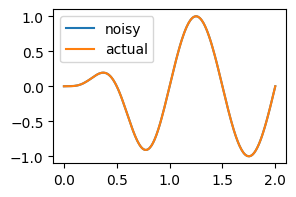

In [12]:
tf = 2.0
dt = 0.005
ts = np.arange(0, tf + dt, dt)

rs = []
rds = []
rdds = []
for t in ts:
    r, rd, rdd = linear_traj(t)
    rs.append(r)
    rds.append(rd)
    rdds.append(rdd)
rs, rds, rdds = map(np.asarray, (rs, rds, rdds))

np.random.seed(0)
# TODO(eric.cousineau): Provide noise of certain freq?
noise = np.random.uniform(-0.1 * dt, 0.1 * dt, size=rs.shape)
rns = rs + noise

plt.figure(figsize=(3, 2))
plt.plot(ts, rns, label="noisy")
plt.plot(ts, rs, label="actual")
plt.legend()
pass

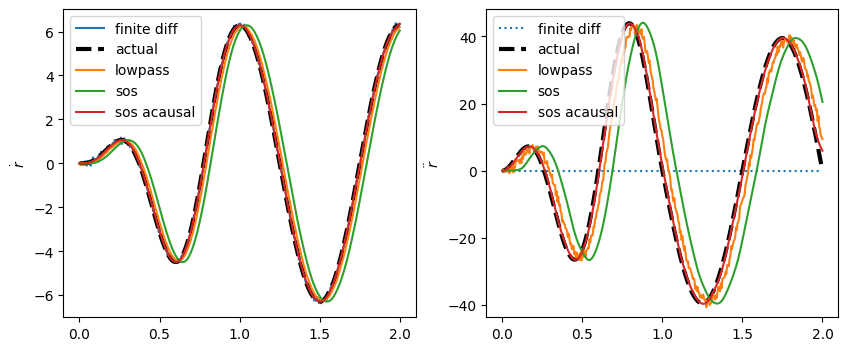

In [13]:
freq = 10
# TODO(eric.cousineau): Er, dunno how to compare frequencies, or actually
# do filter design.
sos = signal.butter(4, freq, fs=1 / dt, output="sos")
alpha = calc_alpha(dt, cutoff_freq=freq)

filt_lp = partial(iir_discrete_lowpass, alpha=alpha)
filt_sos = partial(signal.sosfilt, sos, axis=0)
filt_sos_acausal = partial(signal.sosfiltfilt, sos, axis=0)

rd_raw, rdd_raw = est_signals(ts, rns, filter=None, acc=True)
rd_lp, rdd_lp = est_signals(ts, rns, filter=filt_lp, acc=True)
rd_sos, rdd_sos = est_signals(ts, rns, filter=filt_sos, acc=True)
rd_sosa, rdd_sosa = est_signals(ts, rns, filter=filt_sos_acausal, acc=True)

_, axs = plt.subplots(ncols=2, figsize=(10, 4))
plt.sca(axs[0])
plt.plot(ts, rd_raw, label="finite diff")
plt.plot(ts, rds, "k--", linewidth=3, label="actual")
plt.plot(ts, rd_lp, label="lowpass")
plt.plot(ts, rd_sos, label="sos")
plt.plot(ts, rd_sosa, label="sos acausal")
plt.ylabel("$\dot{r}$")
plt.legend()

plt.sca(axs[1])
plt.plot(ts, 0 * rdd_raw, ":", label="finite diff")
plt.plot(ts, rdds, "k--", linewidth=3, label="actual")
# keep these limits
ylim = plt.ylim()
plt.plot(ts, rdd_lp, label="lowpass")
plt.plot(ts, rdd_sos, label="sos")
plt.plot(ts, rdd_sosa, label="sos acausal")
plt.ylabel("$\ddot{r}$")
plt.ylim(ylim)
plt.legend()
pass

## Try out SO(3) Trajectory Filtering

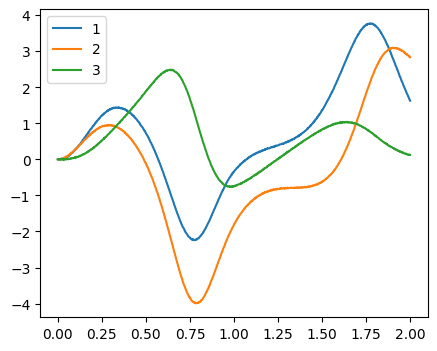

In [14]:
tf = 2.0
dt = 0.002
ts = np.arange(0, tf + dt, dt)

Rs = []
ws = []
wds = []
for t in ts:
    so, coord = so3_traj(t)
    Rs.append(so.R)
    ws.append(so.w)
    wds.append(so.wd)
Rs, ws, wds = map(np.asarray, (Rs, ws, wds))

np.random.seed(0)
# TODO(eric.cousineau): Provide noise of certain freq?
noise = 5 * dt * np.random.uniform(-1, 1, size=ws.shape)
wns = ws + noise

plt.figure(figsize=(5, 4))
plt.plot(ts, wns)
plt.legend(list("123"))
pass

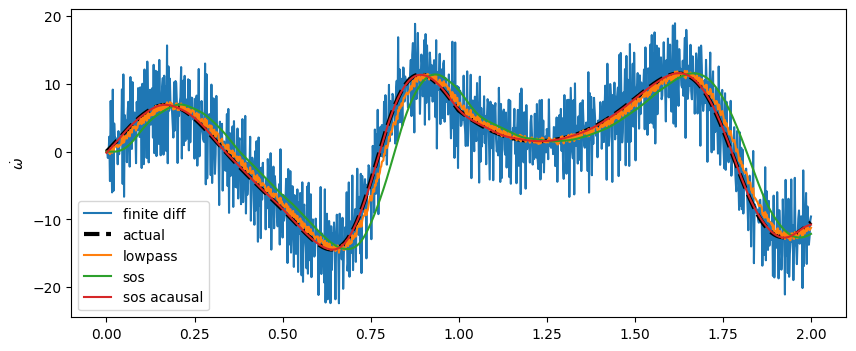

In [15]:
freq = 10
# TODO(eric.cousineau): Er, dunno how to compare frequencies, or actually
# do filter design.
sos = signal.butter(4, freq, fs=1 / dt, output="sos")
alpha = calc_alpha(dt, cutoff_freq=freq)

filt_lp = partial(iir_discrete_lowpass, alpha=alpha)
filt_sos = partial(signal.sosfilt, sos, axis=0)
filt_sos_acausal = partial(signal.sosfiltfilt, sos, axis=0)

wd_raw = est_signals(ts, wns, filter=None, acc=False)
wd_lp = est_signals(ts, wns, filter=filt_lp, acc=False)
wd_sos = est_signals(ts, wns, filter=filt_sos, acc=False)
wd_sosa = est_signals(ts, wns, filter=filt_sos_acausal, acc=False)

plt.figure(figsize=(10, 4))
plt.plot(ts, wd_raw[:, 0], label="finite diff")
plt.plot(ts, wds[:, 0], "k--", linewidth=3, label="actual")
plt.plot(ts, wd_lp[:, 0], label="lowpass")
plt.plot(ts, wd_sos[:, 0], label="sos")
plt.plot(ts, wd_sosa[:, 0], label="sos acausal")
plt.ylabel("$\dot{\omega}$")
plt.legend()
pass

**TODO(eric.cousineau)**: Errr... figure out something useful to do with this info.

At a minimum, the acausal seems 'aight?